# Retirement Planner

---

## Environment Setup

In [120]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [121]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [122]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [123]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [124]:
# Display sample data
df.head()

,AGG,SPY
,close,close
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [137]:
# Setup the Monte Carlo Parameters
number_simulations = 100    #By the time Metin and I figured out why my loop wasn't working correctlly it was 11pm, so I set number of simulations to 100 to make sure I got time to run it. 
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [138]:
# Calculate the daily roi for the stocks
daily_returns =df.pct_change()

# Display sample data
daily_returns.head()
# Compute daily volatility
daily_volatility = daily_returns.std()
spy_volatility = daily_volatility["SPY"]["close"]
agg_volatility = daily_volatility["AGG"]["close"]

# Save the last day's closing price
spy_last_price = df["SPY"]["close"][-1]
agg_last_price = df["AGG"]["close"][-1]

In [139]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    print(f"Running Simulation {x}...")
    
    # Create the initial simulated prices array seeded with the last closing price
    spy_prices = [spy_last_price]
    agg_prices = [agg_last_price]
    
    # Simulate the returns for 20 years
    for _ in range(number_records):
        spy_prices.append(
            spy_prices[-1] * (1 + np.random.normal(daily_returns.mean()["SPY"]["close"], spy_volatility)))
        agg_prices.append(
            agg_prices[-1] * (1 + np.random.normal(daily_returns.mean()["AGG"]["close"], agg_volatility)))

    # Create a DataFrame of the simulated prices
    portfolio = pd.DataFrame({
        "SPY Simulated Prices": spy_prices,
        "AGG Simulated Prices": agg_prices
    })

    # Calculate the Portfolio Daily Returns
    portfolio_returns=portfolio.pct_change()
    
    # Set the Portfolio Weights (Assume a 60/40 stocks to bonds ratio)
    stocks_weight = 0.60
    bonds_weight = 0.40
    
    
    # Calculate the weighted portfolio return: 
    portfolio_returns = stocks_weight * portfolio_returns["SPY Simulated Prices"] + bonds_weight * portfolio_returns["AGG Simulated Prices"]
    
    # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + portfolio_returns.fillna(0)).cumprod()

Running Simulation 0...
Running Simulation 1...
Running Simulation 2...
Running Simulation 3...
Running Simulation 4...
Running Simulation 5...
Running Simulation 6...
Running Simulation 7...
Running Simulation 8...
Running Simulation 9...
Running Simulation 10...
Running Simulation 11...
Running Simulation 12...
Running Simulation 13...
Running Simulation 14...
Running Simulation 15...
Running Simulation 16...
Running Simulation 17...
Running Simulation 18...
Running Simulation 19...
Running Simulation 20...
Running Simulation 21...
Running Simulation 22...
Running Simulation 23...
Running Simulation 24...
Running Simulation 25...
Running Simulation 26...
Running Simulation 27...
Running Simulation 28...
Running Simulation 29...
Running Simulation 30...
Running Simulation 31...
Running Simulation 32...
Running Simulation 33...
Running Simulation 34...
Running Simulation 35...
Running Simulation 36...
Running Simulation 37...
Running Simulation 38...
Running Simulation 39...
Running Si

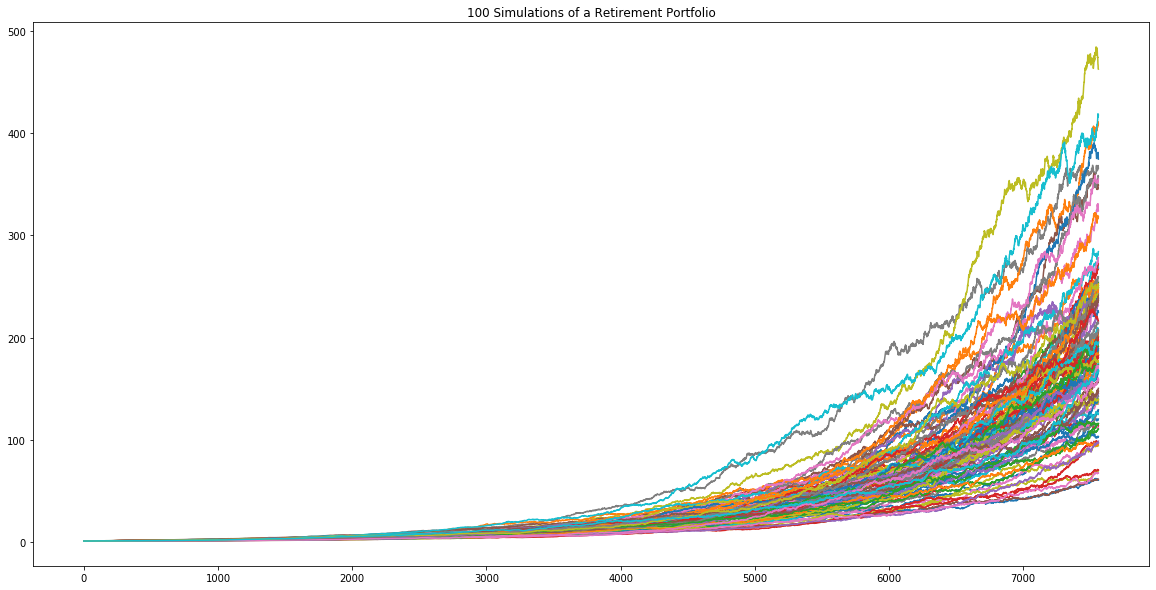

In [140]:
# Visualize the Simulation
plot_title = f"{x+1} Simulations of a Retirement Portfolio"
monte_carlo.plot(legend = None, title = plot_title, figsize = (20,10))

In [141]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
monte_carlo_30years = monte_carlo.iloc[-1, :]    #last index, the entire row
monte_carlo_30years.head()

0    224.965889
1    185.695782
2    254.090683
3    267.175574
4    242.897877
Name: 7560, dtype: float64

In [143]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
monte_carlo_20years = monte_carlo.iloc[-1, :]    #last index, the entire row
monte_carlo_20years.tail()

95    150.356862
96    170.434816
97    259.186913
98    249.378120
99    167.575195
Name: 7560, dtype: float64

In [144]:
# Display the 90% confidence interval for the ending returns
confidence_interval_30_years = monte_carlo_30years.quantile(q=[.05, .5, .95])
confidence_interval_20_years = monte_carlo_20years.quantile(q=[.05, .5, .95])

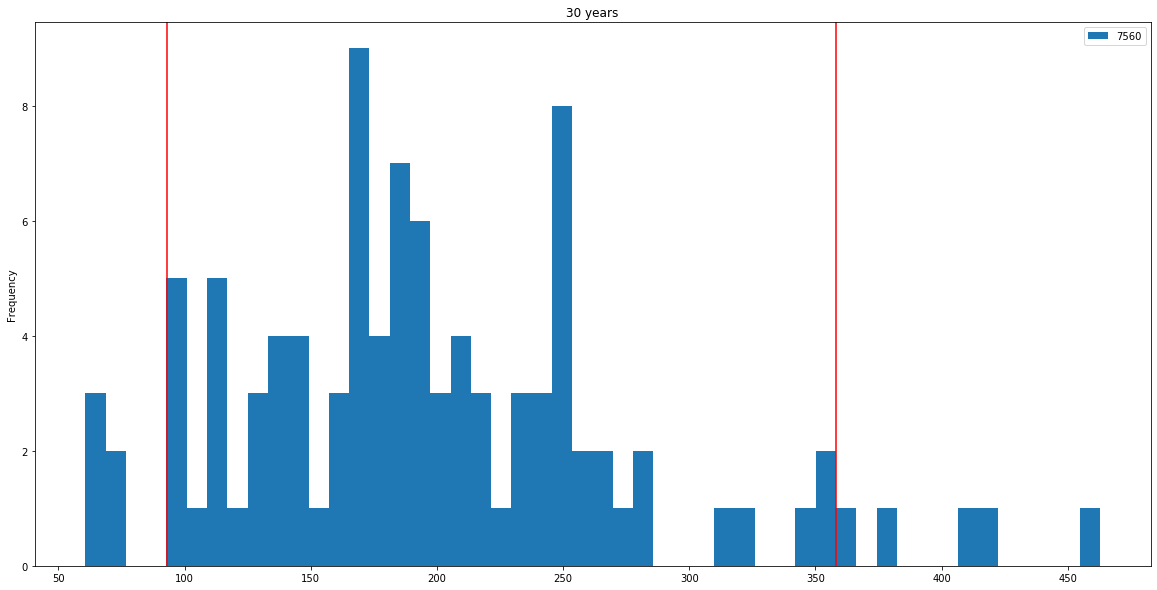

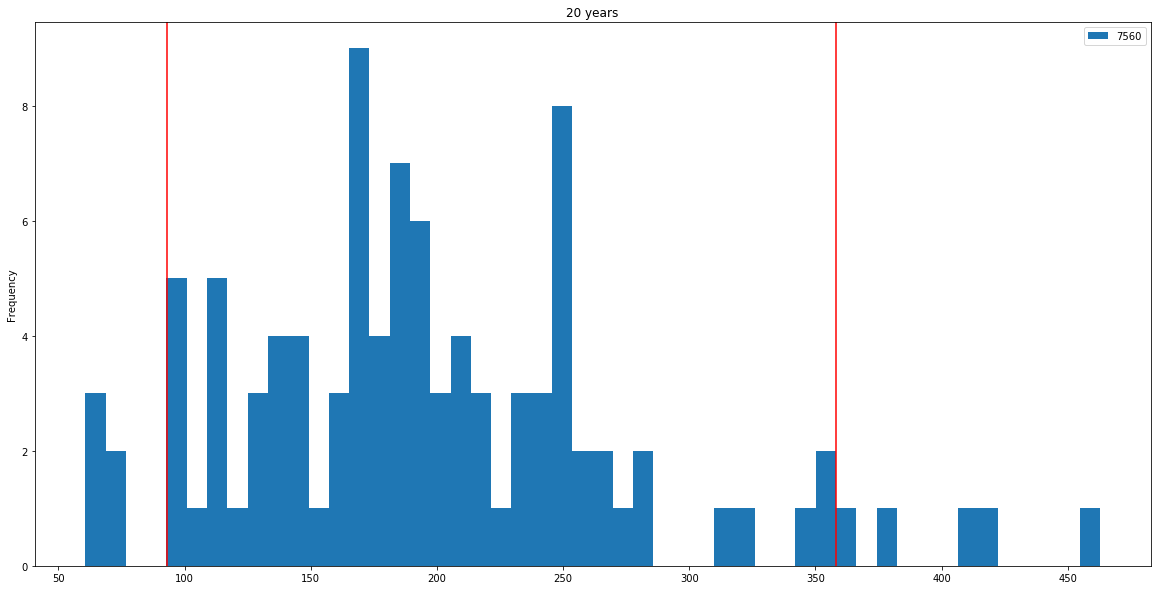

In [145]:
# Visualize the distribution of the ending returns
plt.figure();
monte_carlo_30years.plot(kind = 'hist', bins = 50, title = "30 years", legend = True, figsize = (20,10))
plt.axvline(confidence_interval_30_years.iloc[0], color = 'r')
plt.axvline(confidence_interval_30_years.iloc[2], color = 'r')

plt.figure();
monte_carlo_20years.plot(kind = 'hist', bins = 50, title = "20 years", legend = True, figsize = (20,10))
plt.axvline(confidence_interval_20_years.iloc[0], color = 'r')
plt.axvline(confidence_interval_20_years.iloc[2], color = 'r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [133]:
# Compute cumulative returns
initial_investment = 20000
confidence_interval_30_years = monte_carlo_30years.quantile(q=[0.1, 0.5, 0.9])
tenth = int(confidence_interval_30_years.iloc[0] * initial_investment)
fifty = int(confidence_interval_30_years.iloc[1] * initial_investment)
ninty = int(confidence_interval_30_years.iloc[2] * initial_investment)
print(f"The expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles are ${tenth}, ${fifty}, and ${ninty}, respectively.")

The expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles are $2394105, $3963003, and $7002958, respectively.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [134]:
# Compute expected portfolio return
# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound = initial_investment * confidence_interval_30_years.iloc[0]
investment_pnl_middle_bound = initial_investment * confidence_interval_30_years.iloc[1]
investment_pnl_upper_bound = initial_investment * confidence_interval_30_years.iloc[2]
investment_pnl_lower_bound = int(investment_pnl_lower_bound)
investment_pnl_upper_bound = int(investment_pnl_upper_bound) 
investment_pnl_middle_bound = int(investment_pnl_middle_bound)
# Print the results
print(f"The expected portfolio return for initial investment of $20,000"
      f" over the next 30 Years will end within in the range of 10th percential:"
      f" ${investment_pnl_lower_bound}, 50th percential: ${investment_pnl_middle_bound}"
      f"  and 90th percential: ${investment_pnl_upper_bound}")

The expected portfolio return for initial investment of $20,000 over the next 30 Years will end within in the range of 10th percential: $2394105, 50th percential: $3963003  and 90th percential: $7002958


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [135]:
# Set Plaid's projected income
projected_yearly_income_before_tax = 7389
# Calculate the 4% withdrawal for the ending return as retirement income
# Determine if the retirement income meets or exceeds the current projected income
if (investment_pnl_upper_bound * .04) > projected_yearly_income_before_tax:
    print(f"Yes, the 4% withdrawl from the 10th percentile is {investment_pnl_upper_bound * .04} and is above our Plaid analysis projected annual income of {projected_yearly_income_before_tax}.")
else:
    print(f"No, the 4% withdrawl from the 10th percentile is {investment_pnl_upper_bound * .04} and is at or below our Plaid analysis projected annual income of {projected_yearly_income_before_tax}.")

Yes, the 4% withdrawl from the 10th percentile is 280118.32 and is above our Plaid analysis projected annual income of 7389.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [136]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
investment_pnl_lower_bound_20k = initial_investment * confidence_interval_30_years.iloc[0]
investment_pnl_middle_bound_20k = initial_investment * confidence_interval_30_years.iloc[1]
investment_pnl_upper_bound_20k = initial_investment * confidence_interval_30_years.iloc[2]
investment_pnl_lower_bound_20k = int(investment_pnl_lower_bound_20k)
investment_pnl_upper_bound_20k = int(investment_pnl_middle_bound_20k) 
investment_pnl_middle_bound_20k = int(investment_pnl_upper_bound_20k)
# Print the results
print(f"The expected portfolio return for initial investment of ${initial_investment}"
      f" over the next 30 Years will end within in the range of 10th percential:"
      f" ${investment_pnl_lower_bound_20k}, 50th percential: ${investment_pnl_middle_bound_20k}"
      f"  and 90th percential: ${investment_pnl_upper_bound_20k}")


projected_yearly_income_before_tax = 7389
if (investment_pnl_upper_bound_20k * .04) > projected_yearly_income_before_tax:
    print(f"Yes, the 4% withdrawl from the 10th percentile is ${investment_pnl_upper_bound_20k * .04} and is above our Plaid analysis projected annual income of ${projected_yearly_income_before_tax}")
else:
    print(f"No, the 4% withdrawl from the 10th percentile is ${investment_pnl_upper_bound_20k * .04} and is at or below our Plaid analysis projected annual income of ${projected_yearly_income_before_tax}")
    
print("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
# 50% increase in investment
print("With a 50% increase in investment")

initial_investment_50per = 20000*(1.5)


# Calculate investment profit/loss of lower and upper bound cumulative portfolio returns
investment_pnl_lower_bound_50per = initial_investment_50per * confidence_interval_30_years.iloc[0]
investment_pnl_middle_bound_50per = initial_investment_50per * confidence_interval_30_years.iloc[1]
investment_pnl_upper_bound_50per = initial_investment_50per * confidence_interval_30_years.iloc[2]
investment_pnl_lower_bound_50per = int(investment_pnl_lower_bound_50per)
investment_pnl_upper_bound_50per = int(investment_pnl_middle_bound_50per) 
investment_pnl_middle_bound_50per = int(investment_pnl_upper_bound_50per)

print(f"The expected portfolio return for initial investment of ${initial_investment_50per}"
      f" over the next 30 Years will end within in the range of 10th percential:"
      f" ${investment_pnl_lower_bound_50per}, 50th percential: ${investment_pnl_middle_bound_50per}"
      f"  and 90th percential: ${investment_pnl_upper_bound_50per}")


if (investment_pnl_upper_bound_50per * .04) > projected_yearly_income_before_tax:
    print(f"Yes, the 4% withdrawl from the 10th percentile is ${investment_pnl_upper_bound_50per * .04} and is above our Plaid analysis projected annual income of ${projected_yearly_income_before_tax}")
else:
    print(f"No, the 4% withdrawl from the 10th percentile is ${investment_pnl_upper_bound_50per * .04} and is at or below our Plaid analysis projected annual income of ${projected_yearly_income_before_tax}")

The expected portfolio return for initial investment of $20000 over the next 30 Years will end within in the range of 10th percential: $2394105, 50th percential: $3963003  and 90th percential: $3963003
Yes, the 4% withdrawl from the 10th percentile is $158520.12 and is above our Plaid analysis projected annual income of $7389
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
With a 50% increase in investment
The expected portfolio return for initial investment of $30000.0 over the next 30 Years will end within in the range of 10th percential: $3591158, 50th percential: $5944504  and 90th percential: $5944504
Yes, the 4% withdrawl from the 10th percentile is $237780.16 and is above our Plaid analysis projected annual income of $7389


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
